# Easy SSA and FSP in Julia

In [1]:
# import all the relevant packages.
using Plots, LaTeXStrings, Distributions, DoubleFloats, Plots.PlotMeasures, 
        Catalyst, FiniteStateProjection, OrdinaryDiffEq, DifferentialEquations, 
            SparseArrays, LinearAlgebra, MomentClosure
Plots.theme(:dao)

[ Info: Precompiling DoubleFloats [497a8b3b-efae-58df-a0af-a86822472b78] (cache misses: dep missing source (2))
[ Info: Precompiling PolynomialsChainRulesCoreExt [f5ad5175-ea71-5bad-b0d8-3d77b6894ccb] (cache misses: wrong dep version loaded (2))
[ Info: Precompiling PolynomialsMutableArithmeticsExt [2016f45f-0850-5d4f-b1e3-7a95b670587c] (cache misses: wrong dep version loaded (2))
[ Info: Precompiling FiniteStateProjection [069e79ea-d681-44e8-b935-95bdaf9e8f28] (cache misses: dep missing source (2))


## SSA in Julia

The code below shows how to easily employ the SSA in Julia for an autoregulatory reaction network:
$$
    G \xrightarrow[]{\rho_u} G + P, \ P \xrightarrow[]{d} \varnothing, \ P + G \xrightarrow{\sigma_b}G^*, \ G^*\xrightarrow{\sigma_u}G+P, \ G^* \xrightarrow[]{\rho_b} G^* + P.
$$

In [2]:
"""code adapted from similar code in the docs of MomentClosure.jl."""
# define the reaction network in Catalyst
rn = @reaction_network begin
    ρu, G → G + P
    ρb, Gs → Gs + P
    σu, Gs → G
    σb, G + P → Gs + P
    d, P → 0
end

# define the initial condition and parameters
p = (:ρu => 1.0, :ρb => 50.0, :σu => 1.0, :σb => 0.9, :d => 1) # order ρu ρb σu σb d [1.0,50.0,1.0,0.9,1]
speciesmap(rn)           # gives the indices of each species in sol_SSA below.
u₀ = [:G=>1,:P=>0,:Gs=>0]             # define the initial condition, here: G=1, P=0, G*=0.
tspan = (0.0,20.0)       # define the time range of the simulation.

# create a DiscreteProblem encoding that molecule numbers are integer valued.
dprob = DiscreteProblem(rn, u₀, tspan, p)

# create the jump problem.
jprob = JumpProblem(rn, dprob, Direct(), save_positions=(false,false))

# define the EnsembleProblem to simulate multiple traj
ensembleprob = EnsembleProblem(jprob)

# simulate 10000 SSA traj
@time sol_SSA = solve(ensembleprob, SSAStepper(), saveat=0.01, trajectories = 10000)
"""sol_SSA[i,k,j]: ith species, of the kth timestep, for the jth traj"""

# take the SSA times
times = sol_SSA[1].t;

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase ~/.julia/packages/SciMLBase/8XHkk/src/performance_warnings.jl:32


  4.994183 seconds (41.99 M allocations: 1.891 GiB, 44.92% gc time, 14.14% compilation time: 4% of which was recompilation)


In [4]:
times;

Create a color blind friendly scheme for the plots.

In [5]:
# xts = [latexstring(s) for s in names(pars_mech[1,:])];
xts = [L"k_{on}", L"k_{off}", L"k_c", L"k_{rc}", L"k_{op}", L"k_{in}", L"k_e"]
gene_names = [join([L"\mathrm{Gene}\;",i]) for i in 1:11]
pal = cgrad(:tol_muted);
[pal[i] for i in 0.1:0.1:0.7]

Plot three of the SSA trajectories.

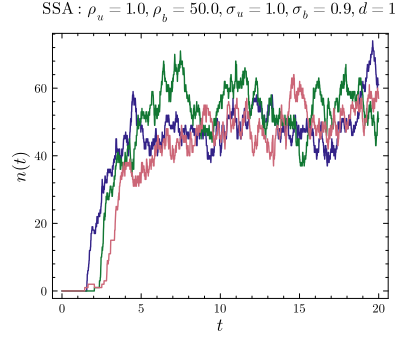

In [6]:
ssas = plot(times,sol_SSA[2,:,1:3], legend=:none, lc=[pal[1] pal[4] pal[7]])
plot!(size=(400,350))
xlabel!(L"t")
ylabel!(L"n(t)")
plot!(grid = false, minorgrid = false)
title!(L"\mathrm{SSA}: \rho_u=1.0,\rho_b=50.0,\sigma_u=1.0,\sigma_b=0.9,d=1",titlefontsize=11)

It appears that as we reach $t=20$ the trajectories reach their steady state (independent of the initial condition).

## Steady state FSP in Julia 

For the steady state FSP one needs to enforce the conservation law $n_G+n_{G^*}=1$ explicitly on the reaction network.

In [18]:
# Define the reaction network
rnFSP = @reaction_network begin
    (ρu), G → G + P
    (ρb*(1-G)), 0 → P
    (σu*(1-G)), 0 → G
    (σb), G + P → P
    (d), P → 0
end

# Define the FSP system
sys = FSPSystem(rnFSP)
sm = speciesmap(rnFSP)
dims = (2,201) # 2 gene states (G=0 or 1), and truncate the protein numbers at 200 (note can have 0 proteins).
mat = SparseMatrixCSC(sys, dims, p, 0.0) # return the matrix \overbar{M}.


# Solve the FSP at steady state: designated state is (1,0)
mat[1,:] = ones(size(mat)[1])
b = zeros(size(mat)[1]); b[1] = 1;
# Solve the linear algebra problem.
@time sol = mat\b

# reshape the solution so it can be interpretted.
reshaped_sols = reshape(sol, dims)

# Find the marginal distribution for P evaluated over the sum of all other dims.
P_marg = vcat(sum(reshaped_sols,dims=(1))...);

  0.284196 seconds (390.77 k allocations: 21.023 MiB, 94.80% compilation time)


Now, compare the SSA histogram to the steady state FSP solution.

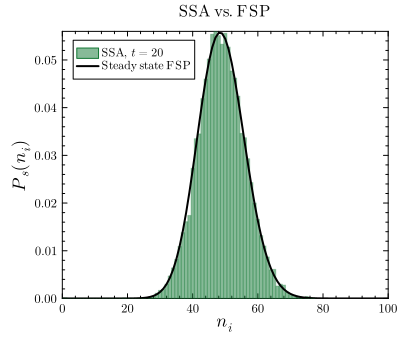

In [22]:
SSA_t5 = sol_SSA[2,2001,:]
ssavsfsp = histogram(SSA_t5, bins = collect(range(-0.5,maximum(SSA_t5)+0.5,length=maximum(SSA_t5)+2)),lw=1,linealpha=0.3, alpha=0.5, norm=true, fc = pal[4], lc = pal[4], label=L"\mathrm{SSA},\, t = 20", legend=:topleft)
plot!(0:length(P_marg)-1,P_marg, label = L"\mathrm{Steady\; state\; FSP}", lc = :black, c=:2, lw = 2)

xlims!(0,100)
plot!(size=(400,350))
xlabel!(L"n_i")
ylabel!(L"P_s(n_i)")
plot!(grid = false, minorgrid = false)
title!(L"\mathrm{SSA\; vs. FSP}",titlefontsize=11)

Note, comparison of the time taken between the FSP and SSA should reveal that the FSP is $\sim$ $10^3-10^4$ times faster than the SSA.

In [97]:
# plot(ssas, ssavsfsp, layout=(2,1))
# plot!(size=(400,600))
# savefig(join([pwd(),"/SSSandFSP.pdf"]))